# Analysis of Xenium ( considering non-expanded cells)

This script shows how to analyze a typical Xenium segmented dataset. The analysis is based on Scanpy (documentation in  https://scanpy.readthedocs.io/en/stable/index.html) and Squidpy (documentation in https://squidpy.readthedocs.io/en/stable/)

## Loading the packages

We import the packages needed for it. If something fails, means that we haven't installed something in the environment

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import xb.plotting as xp
import xb.formatting as xf

# Load the functions

## Importing the data and creating an anndata object

In this case we aim to keep just the nuclear information.That's why 

In [2]:
adata1=sc.read(r"../../data/unprocessed_adata/h_breast_1.h5ad")

In [3]:
adata=adata1[:,adata1.var['in_panel']]

The object where our data is contained is called anndata (documentation in https://anndata.readthedocs.io/en/latest/). The expression is stored in adata.X. The metadata is stored in adata.obs. The data associated with the genes is stored in adata.var

In [4]:
adata.obs

cell_id   x_centroid   y_centroid  transcript_counts  \
0            1   849.753723    45.673801                 94   
1            2   823.183350    57.322746                 73   
2            3   835.742249    60.938423                151   
3            4   845.734009    65.249466                125   
4            5   833.372620    70.787758                121   
...        ...          ...          ...                ...   
37316    37317  3442.737549  2667.384277                 39   
37317    37318  3453.798828  2683.199463                 46   
37318    37319  3337.515625  2683.341553                 56   
37319    37320  3342.276855  2704.519531                 66   
37320    37321  3401.203125  2707.002441                  2   

       control_probe_counts  control_codeword_counts  total_counts  \
0                         0                        0            94   
1                         0                        0            73   
2                         0                        0           151   
3                         0                        0           125   
4                         0                        0           121   
...                     ...                      ...           ...   
37316                     0                        0            39   
37317                     0                        0            46   
37318                     0                        0            56   
37319                     0                        0            66   
37320                     0                        0             2   

         cell_area  nucleus_area  
0       120.476875     10.747188  
1       184.824531     16.798125  
2       146.351406     25.377813  
3       156.330938     24.158594  
4       175.115938     27.816250  
...            ...           ...  
37316   257.119687     15.849844  
37317   163.239844     15.082187  
37318   423.972031     15.262813  
37319   532.166406     35.221875  
37320  1011.138750     17.520625  

[37321 rows x 9 columns]

Define folder where we'll save all outputs and create it if it didn't exist

In [4]:
output_folder='celltype_identification_hbreast_idc'

In [5]:
import os
if  not os.path.exists('../../figures/'+output_folder):
    os.mkdir('../../figures/'+output_folder)

 We calculate the total number of reads in each cell and store it in 'total_counts'.We keep cells with more than X reads and less than Y reads

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


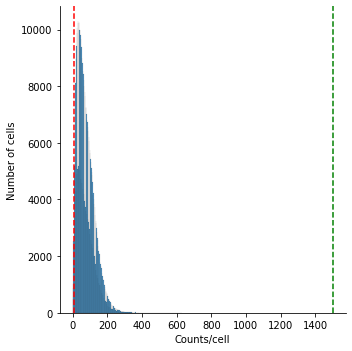

In [6]:
maximum_number_of_reads=1500
minimum_number_of_reads=10
adata.obs=adata.obs.reset_index()
adata.obs['total_counts']=list(np.sum(adata.X,axis=1))
sns.displot(adata.obs,x='total_counts')
plt.xlabel('Counts/cell')
plt.ylabel('Number of cells')
plt.axvline(x=maximum_number_of_reads,color='green',linestyle='--')
plt.axvline(x=minimum_number_of_reads,color='red',linestyle='--')
sc.pp.filter_cells(adata,min_counts=minimum_number_of_reads)
sc.pp.filter_cells(adata,max_counts=maximum_number_of_reads)
plt.savefig('../../figures/'+output_folder+'/countsxcell_histogram.pdf')

# Normalization of the data

We now save the raw data in adata.raw and apply normalization and log-transformation to minimize the effect of outliers. We also scale the data to give the same importance to all genes in clustering

In [7]:
adata.layers['raw']=sc.AnnData(adata.X,obs=adata.obs,var=adata.var)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

[OPTIONAL] After normalizing and logmarizing, the data we CAN, if we wish, filter only highly variable genes for clustering. This step is key in the analysis of single cell RNA sequencing datasets (with +20.000 genes) but it's not that useful in targeted methods such as ISS. However, it can help to keep variables only for clustering

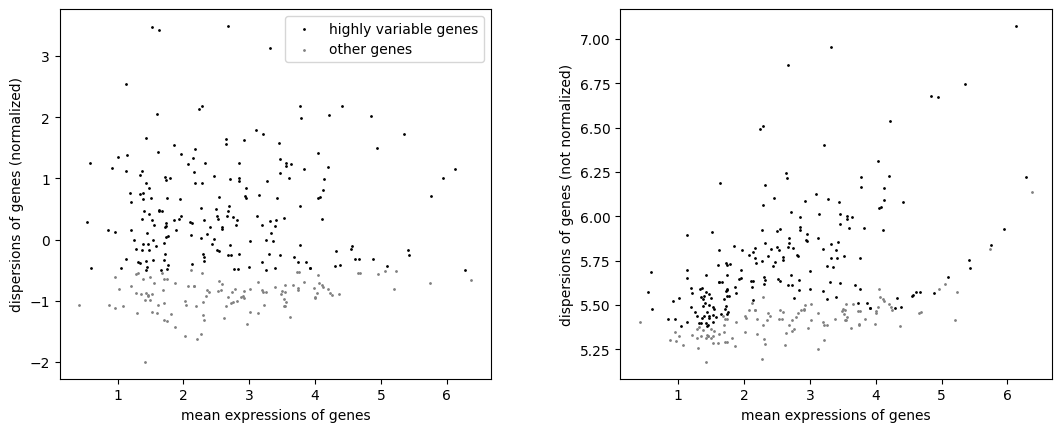

In [8]:
plt.rcParams['figure.facecolor'] = 'white'
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=7, min_disp=-0.5)
sc.pl.highly_variable_genes(adata)
#adata=adata[:,adata.var.highly_variable==True]

[OPTIONAL] We can also scale the data. This means that we scale the expression of every gene between 0 and 1. This will give decrease the impact of highly expressed genes and will increase the importance of lowly expressed genes

In [9]:
#let's not scale in this case
sc.pp.scale(adata,max_value=100)

# Dimensional reduction and clustering

We apply principal component analysis to find the appropiate nubmer of components to use to perform dimensionality reduction and clustering

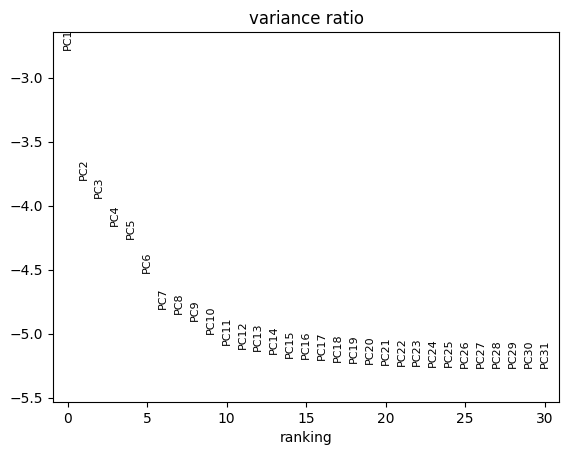

In [10]:
sc.tl.pca(adata, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(adata, log=True)

We select to go with the top X first principal components to look for the nearest neighbors. We are going to represent our data using graph-based methods, like UMAP. For this, we first need to create a graph by linking each cell to the n closest neighbors (n_neighbors) in the dataset. We can select the numbers of principal components to use

In [11]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

/home/sergioms/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can, then, run clustering, by calling either leiden or louvain clustering. By changing the parameter "resolution" we will generate more or less clusters. Higher resolution means more clusters. The clusters (groups of cells) are indepent from its visualization, which we will create using UMAP later on

In [ ]:
sc.tl.leiden(adata,resolution=2.2,key_added='leiden_2_2')
sc.tl.leiden(adata,resolution=1.8,key_added='leiden_1_8')
sc.tl.leiden(adata,resolution=1.4,key_added='leiden_1_4')
sc.tl.leiden(adata,resolution=1.0,key_added='leiden_1_0')
sc.tl.leiden(adata,resolution=0.8,key_added='leiden_0_8')
sc.tl.leiden(adata,resolution=0.6,key_added='leiden_0_6')

To VISUALIZE the diversity of our cells, We perfrom UMAP. The closest two spots are in UMAP, the more similar they will be. With the comand sc.tl.umap. we CALCULATE the UMAP embedding. With sc.pl.umap will VISUALIZE the UMAP.

In [ ]:
sc.tl.umap(adata,min_dist=0.1)

On top of the UMAP you can visualize any variable that you might be interested (a metadata column or gene expression). We need to modify the parameter "color" to visualize the appropiate variable on the UMAP

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(10,10))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,size=30,color=['leiden_1_0'],legend_loc='on data',legend_fontsize=8,legend_fontoutline=2,show=False)
plt.savefig('../../figures/'+output_folder+'/hbreast_leiden_1_0_ondata.pdf',bbox_inches='tight')

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_1_0',method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False, key="wilcoxon",fontsize=25,show=False)
plt.savefig('../../figures/'+output_folder+'/original_leiden_3repl_1_0_deg_update.pdf',bbox_inches='tight')

In [36]:
annotation=pd.read_csv(r"../../data/annotation_dictionaries/number_to_annotation_updated_cluster_3rep_only_nuclei.csv",sep=';')
cluster06_initialannotation=dict(zip(annotation['cluster_0_6'],annotation['original_annotation']))
cluster06_Class=dict(zip(annotation['cluster_0_6'],annotation['Class']))
adata.obs['Class']=adata.obs['leiden_0_6'].astype(int).map(cluster06_Class)
adata.obs['initial_annotation']=adata.obs['leiden_0_6'].astype(str)+'_'+adata.obs['leiden_0_6'].astype(int).map(cluster06_initialannotation)
adata.obs['celltype_annotation']=adata.obs['leiden_0_6'].astype(int).map(cluster06_initialannotation)
adata.obs['cell_code']=list(adata.obs['cell_id'].astype(str)+'_'+adata.obs['replicate'].astype(str))

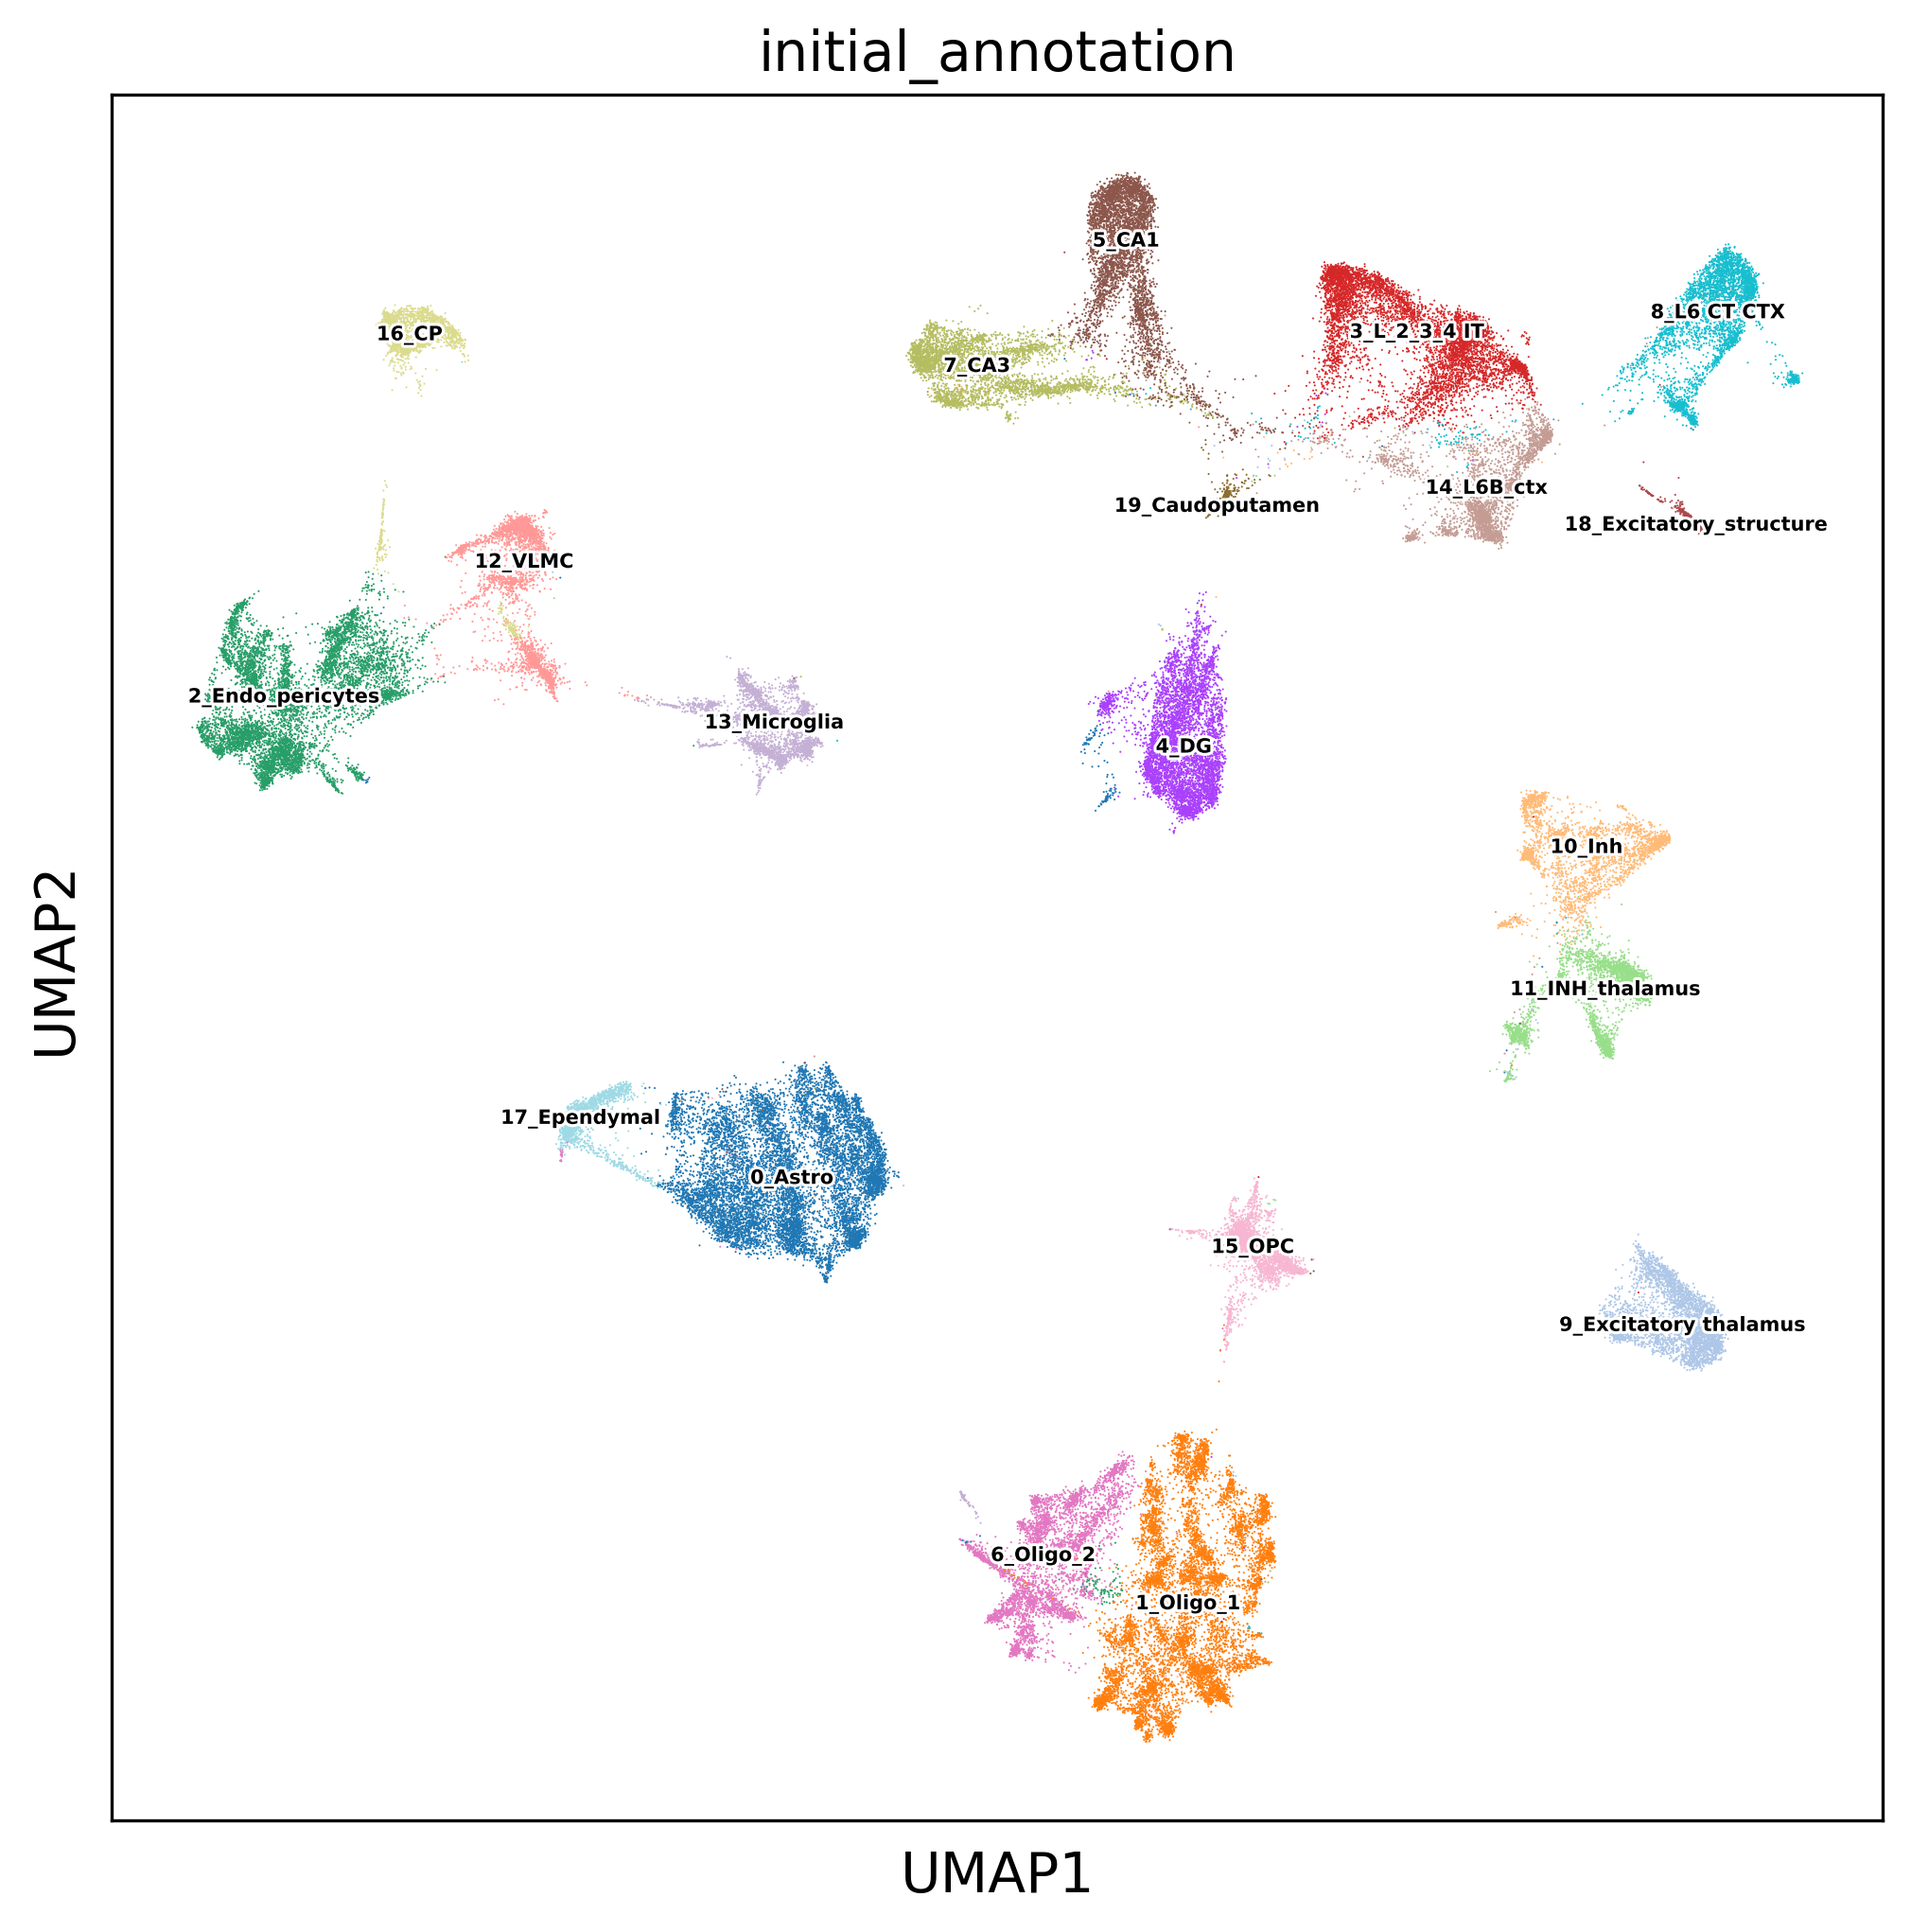

In [37]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(8,8))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=['initial_annotation'],size=1,legend_loc='on data',legend_fontsize=5,legend_fontoutline=1.5,show=False)
plt.savefig('../../figures/'+output_folder+'/msbrain_3rep_initial_annotation_ondata.pdf',bbox_inches='tight')

In [ ]:
adata.obs['X']=adata.obs['x_centroid']*4.70588
adata.obs['Y']=adata.obs['y_centroid']*4.70588
import scipy as sp
adata.X = sp.sparse.csr_matrix(adata.X)

In [ ]:
saving_path=r'../../data/processed_adata'
adata.write(saving_path+'/adata_hbreast_2_idc.h5ad')

# Take annotation from expanded and project them on this dataset

In [40]:
adata_exp=sc.read(saving_path+'/adata_hbreast1.h5ad')
transdict=dict(zip(adata_exp.obs['cell_code'],adata_exp.obs['Class']))
transdict_anno=dict(zip(adata_exp.obs['cell_code'],adata_exp.obs['initial_annotation']))
adata.obs['expanded_class']=list(adata.obs['cell_code'].map(transdict))
adata.obs['expanded_initial_annotation']=list(adata.obs['cell_code'].map(transdict_anno))

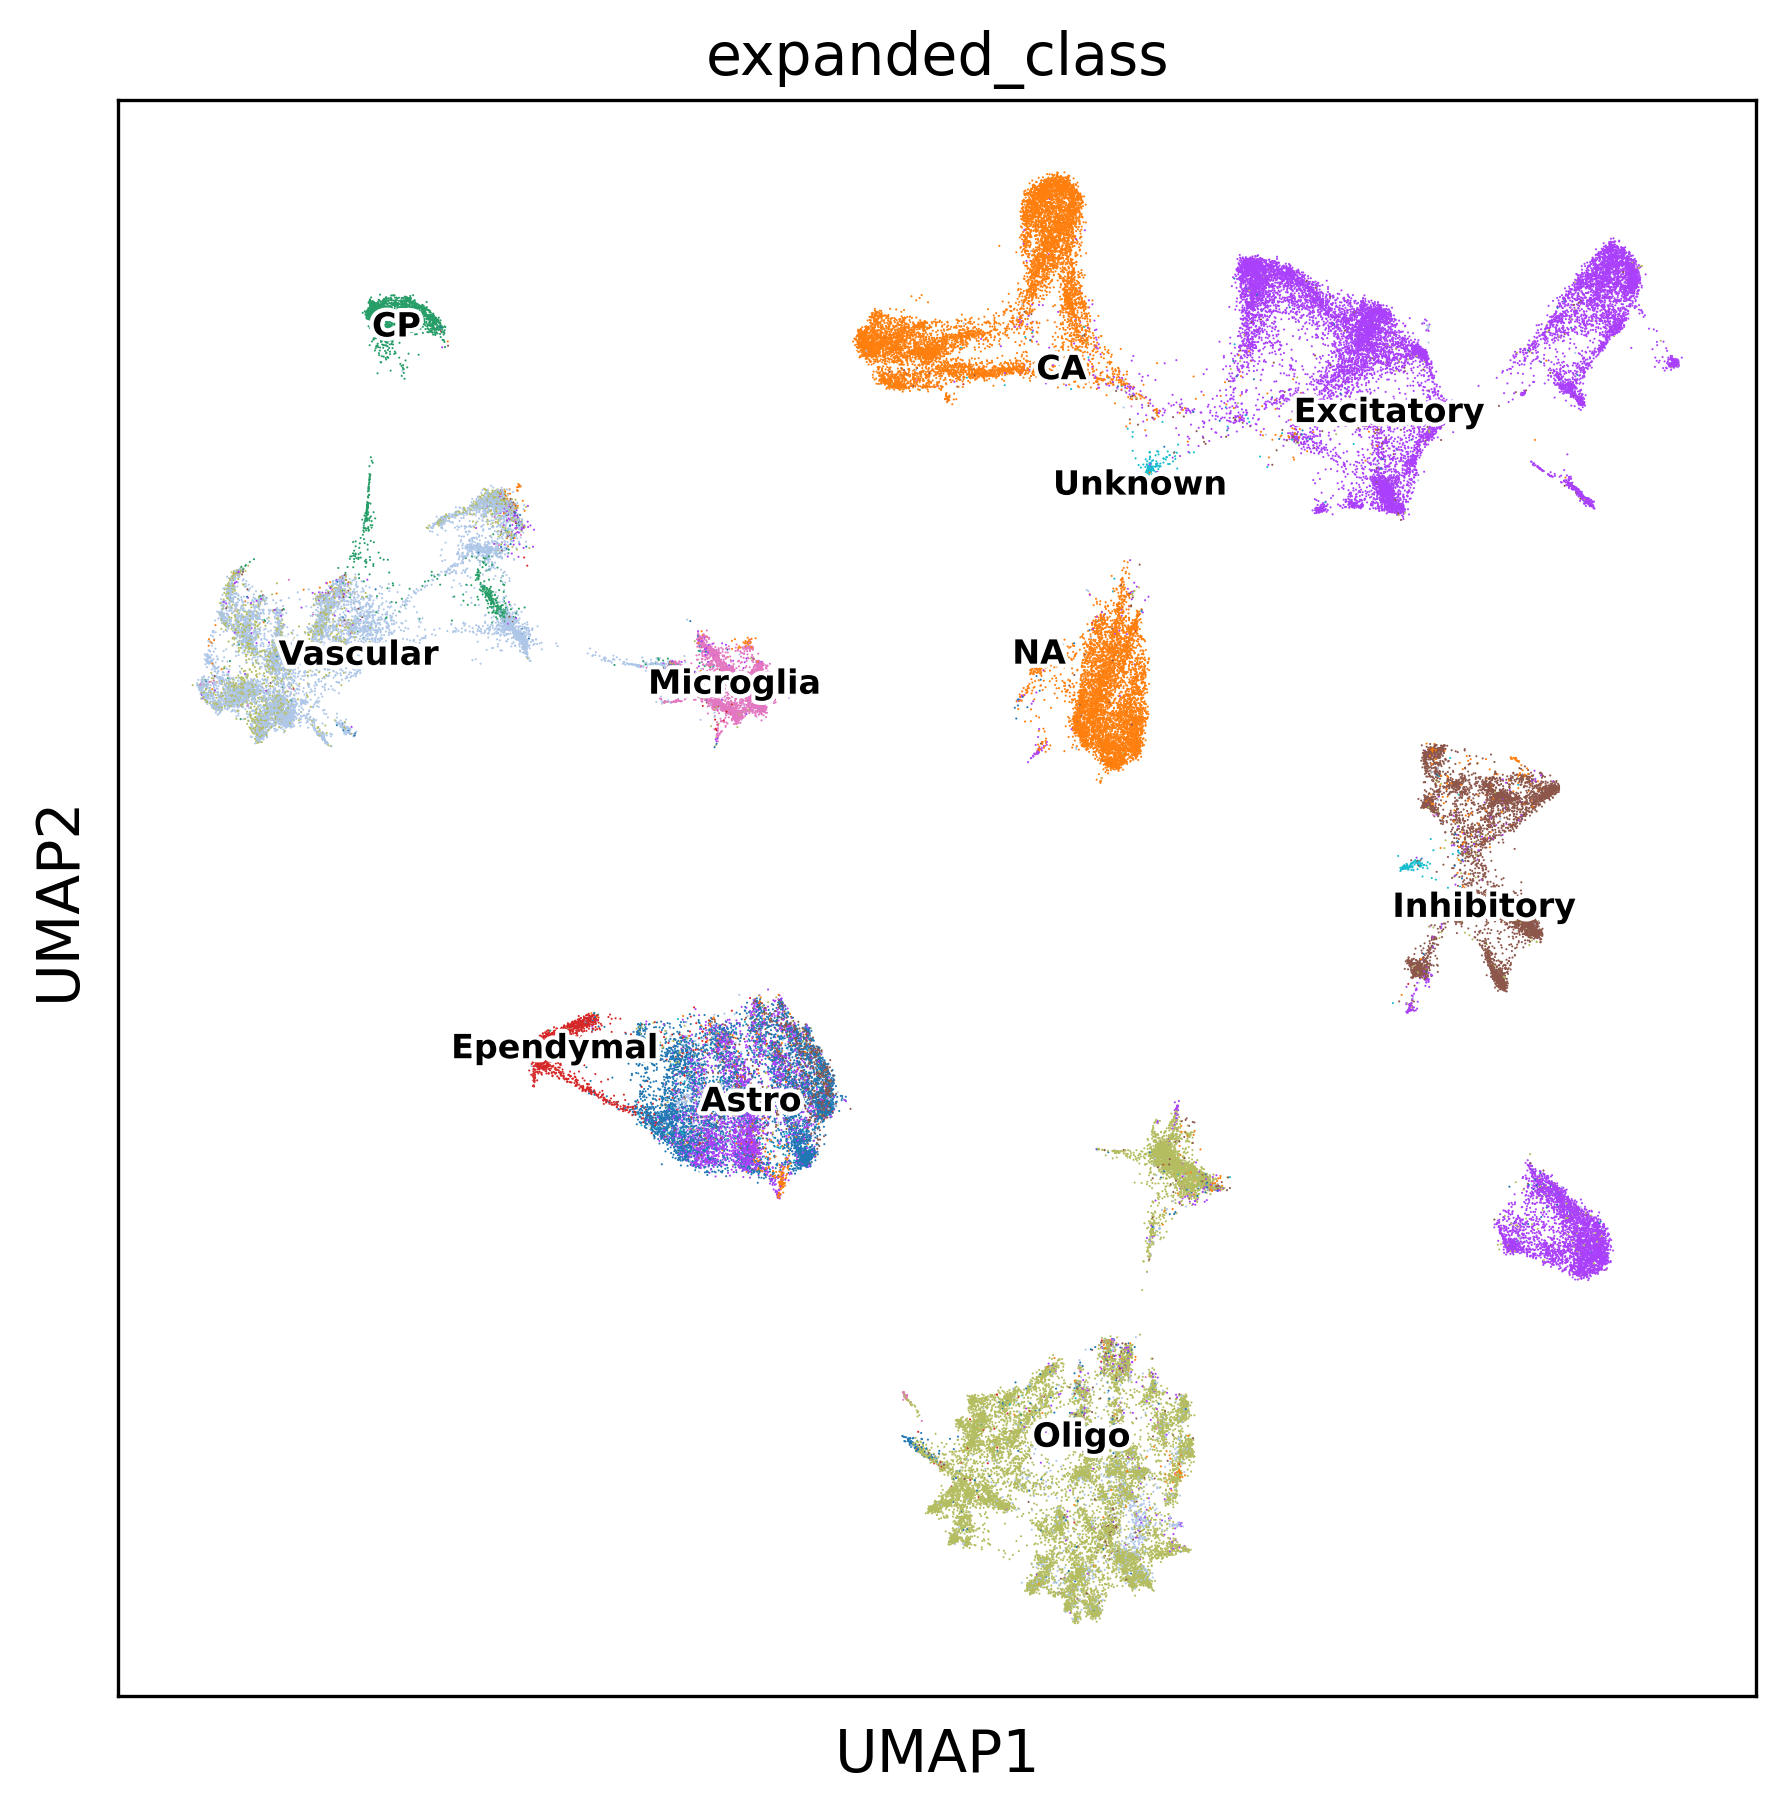

In [42]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(7,7))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=['expanded_class'],size=1,legend_loc='on data',legend_fontsize=8,legend_fontoutline=2,show=False)
plt.savefig('../../figures/'+output_folder+'/msbrain_3rep_expanded_projected_class_ondata.pdf',bbox_inches='tight')

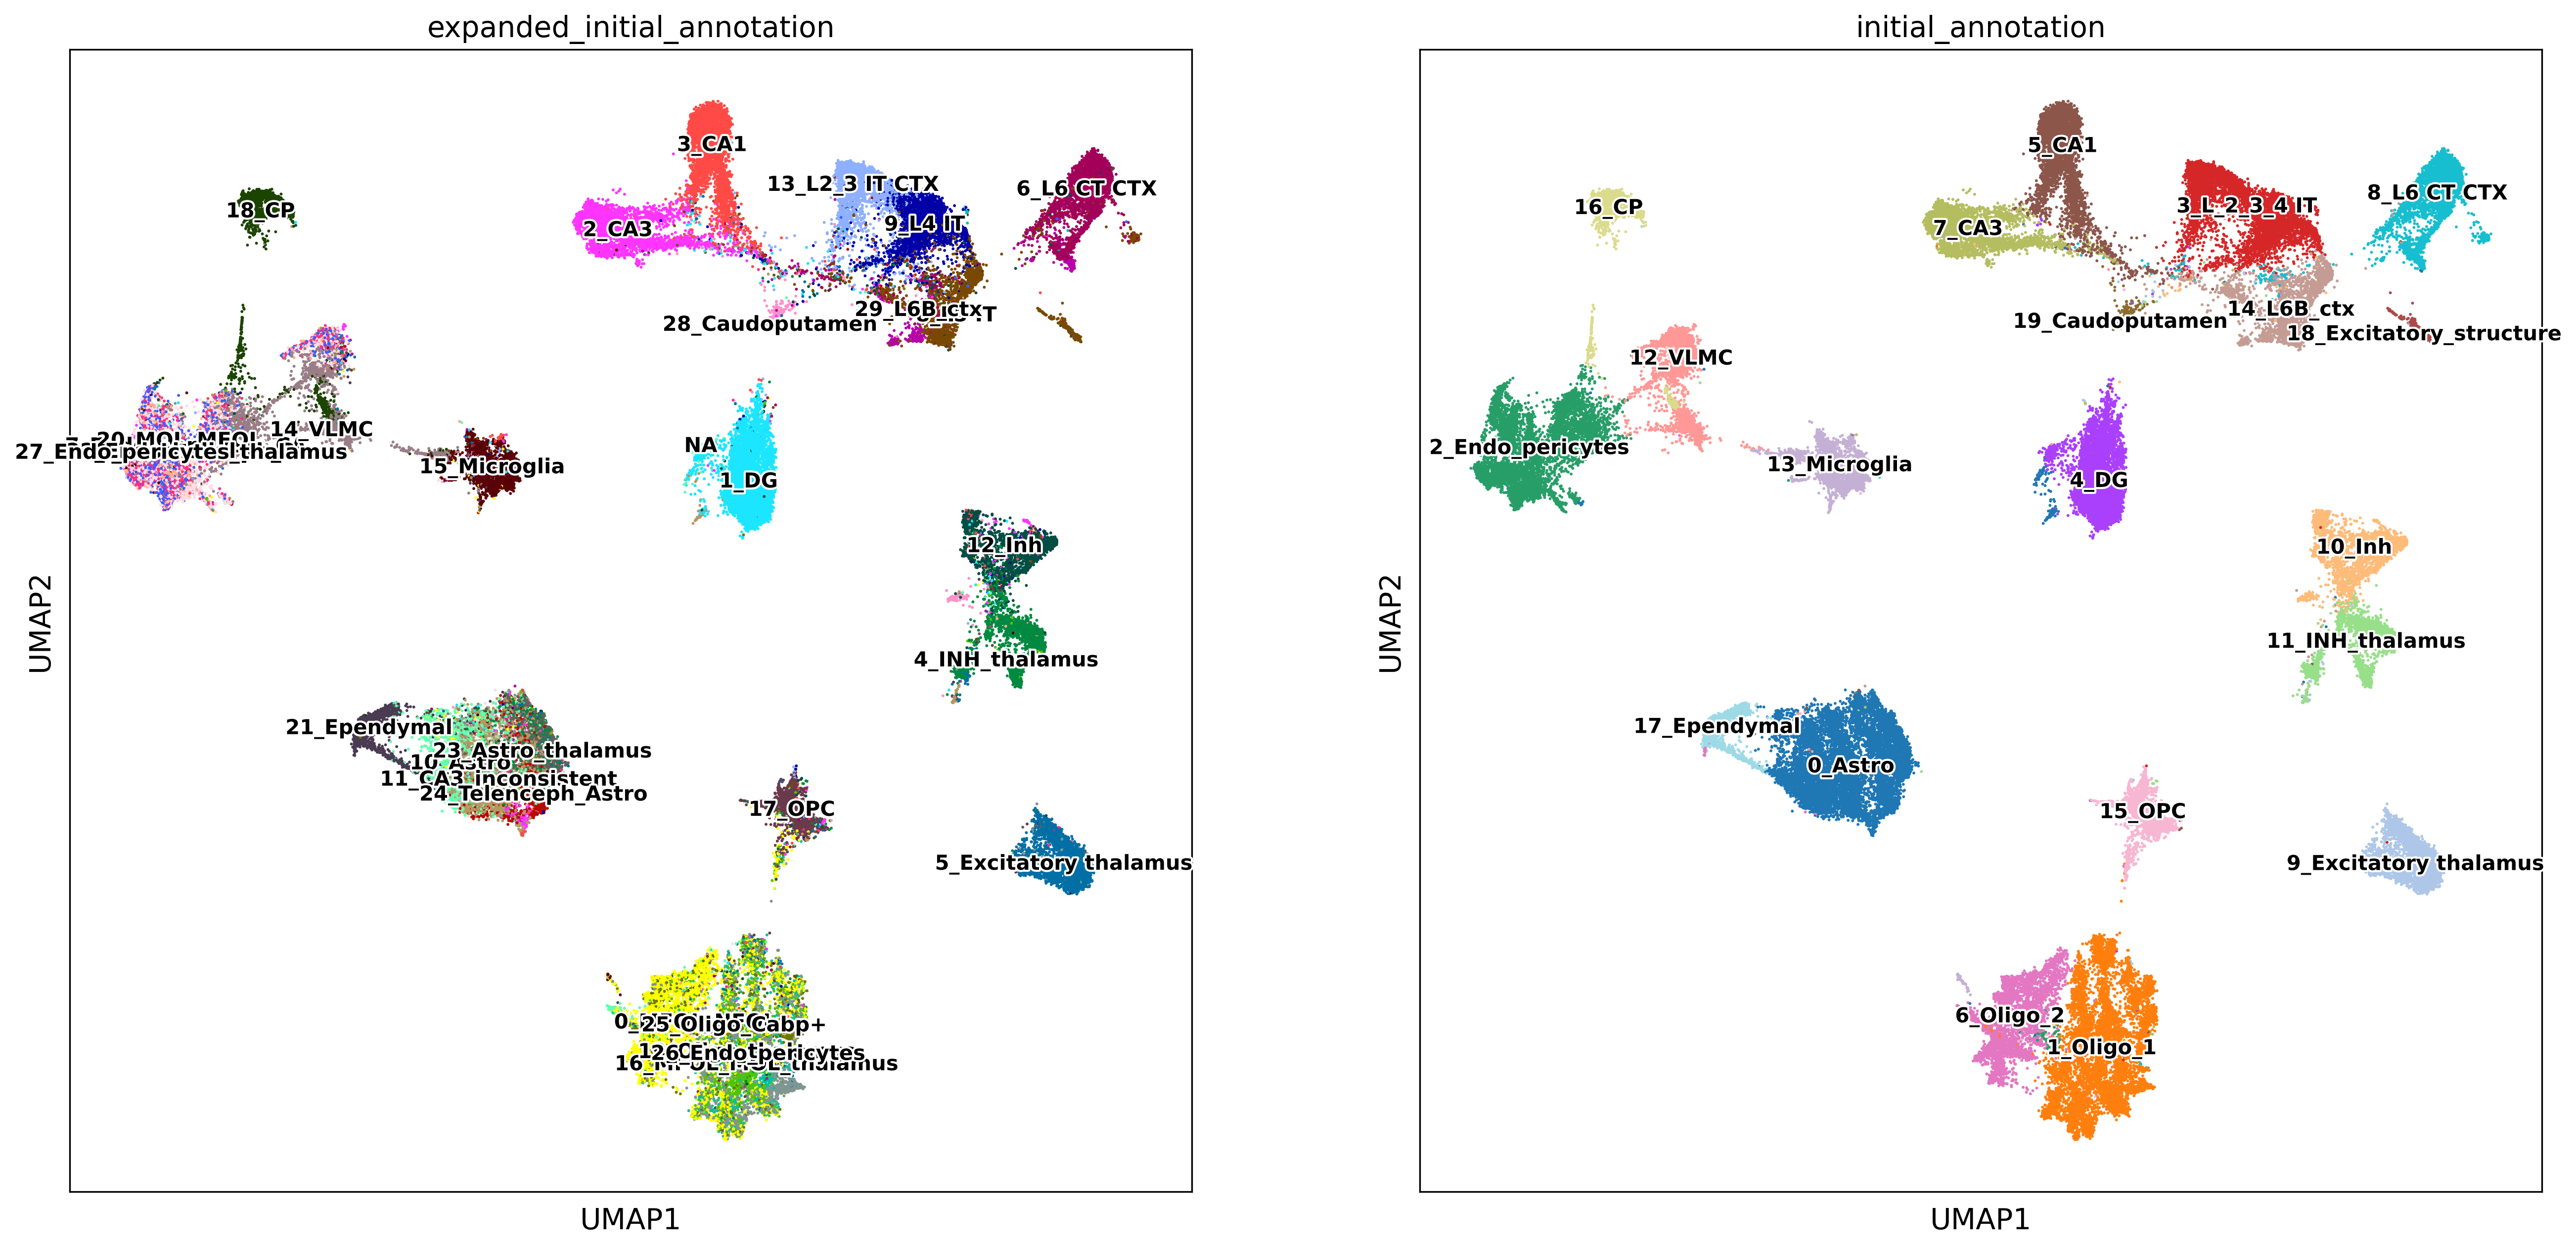

In [43]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(10,10))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=['expanded_initial_annotation','initial_annotation'],size=8,legend_loc='on data',legend_fontsize=10,legend_fontoutline=2,show=False)
plt.savefig('../../figures/'+output_folder+'/msbrain_3rep_expanded_vs_nuclei_annotation.pdf',bbox_inches='tight')

# Plot additional plots

In [27]:
adata.obs.columns

Index(['index', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts',
       'control_probe_counts', 'control_codeword_counts', 'total_counts',
       'cell_area', 'nucleus_area', 'n_counts', 'leiden_2_2', 'leiden_1_8',
       'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6'],
      dtype='object')

In [28]:
plotting=['transcript_counts',
       'control_probe_counts', 'control_codeword_counts', 'total_counts',
       'cell_area', 'nucleus_area', 'n_counts', 'leiden_2_2', 'leiden_1_8',
       'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6']

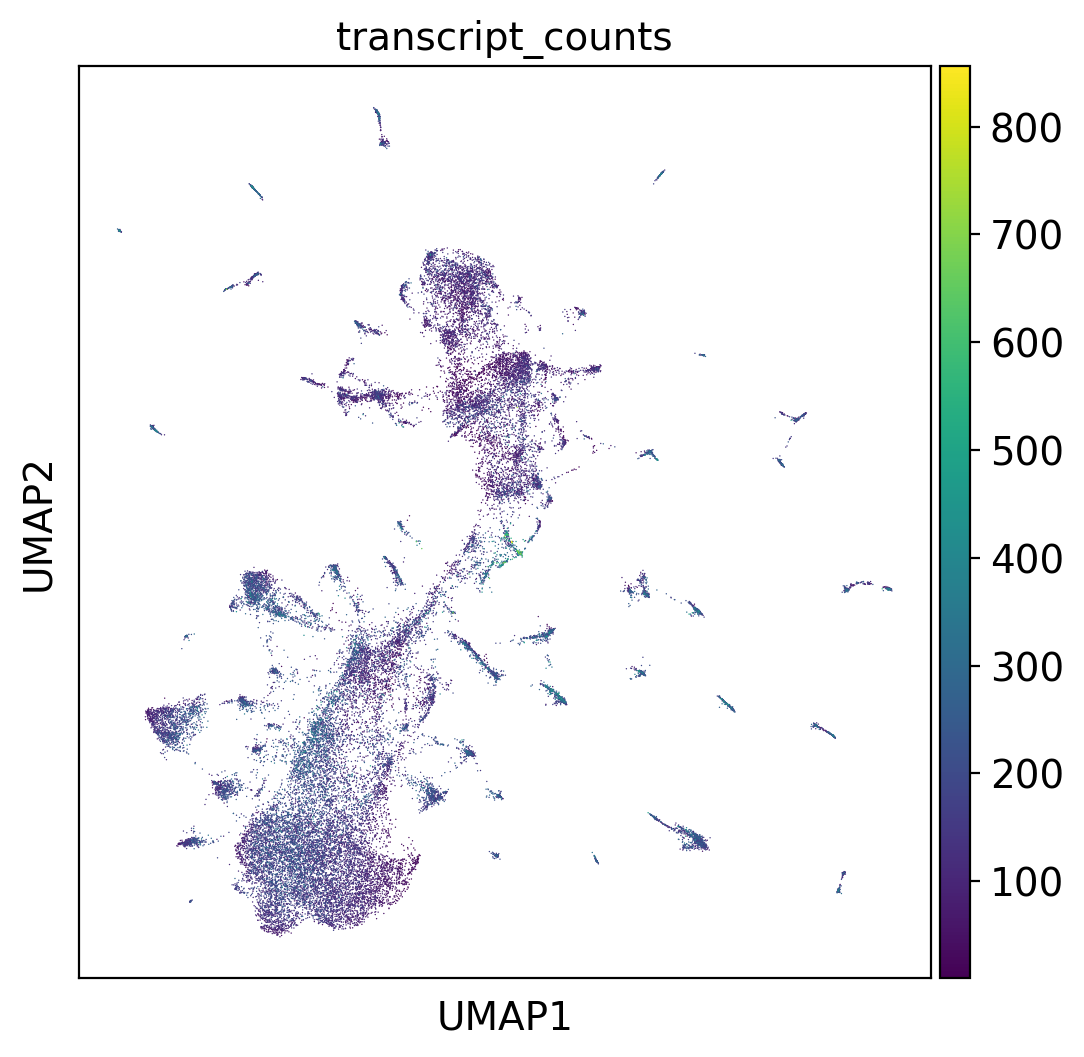

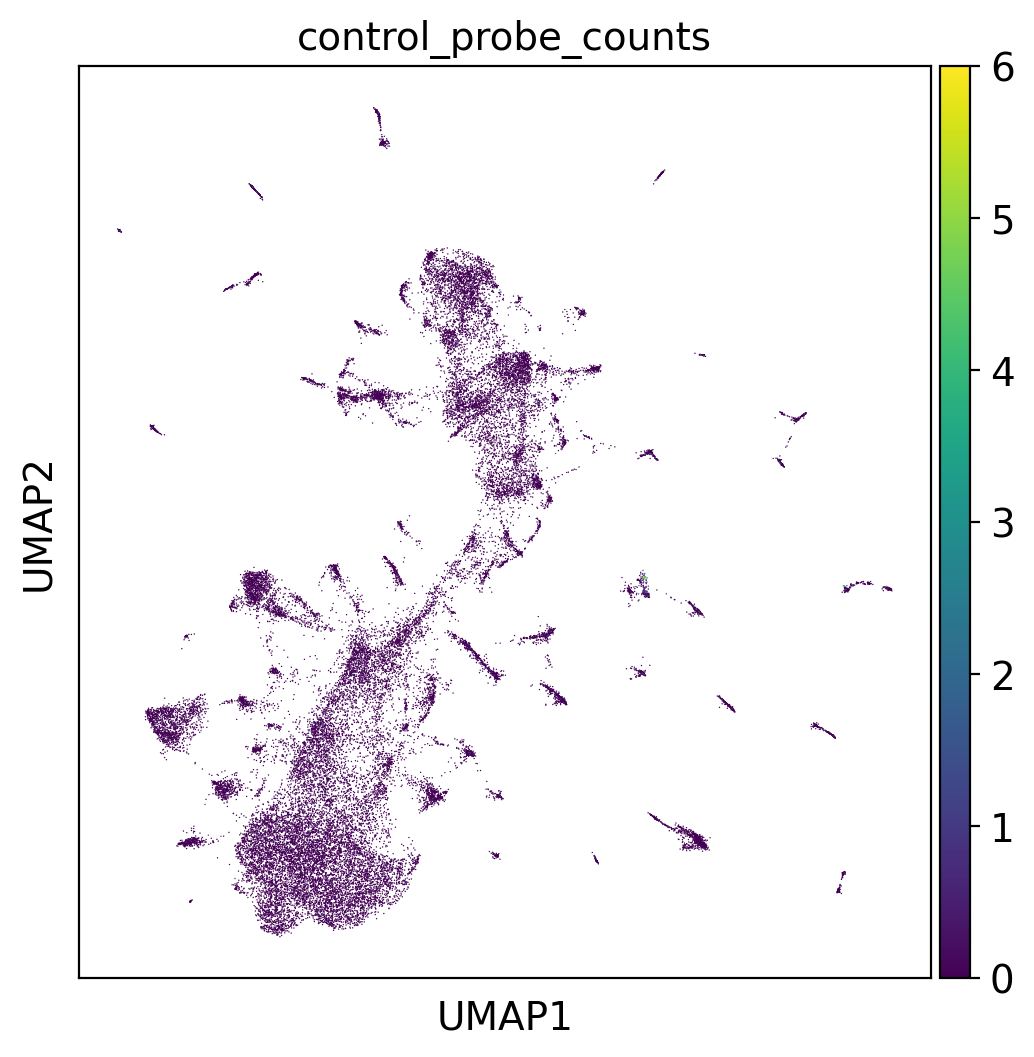

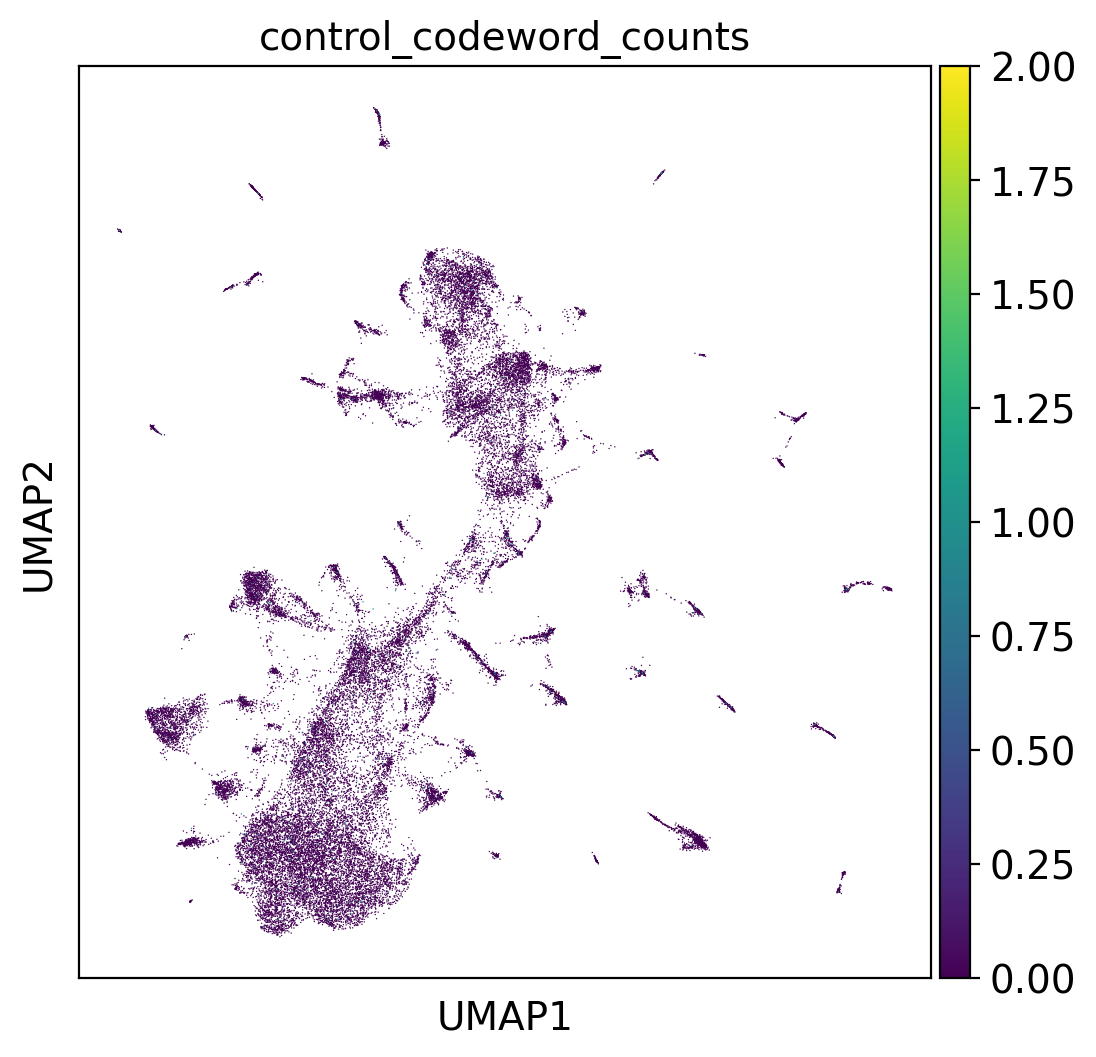

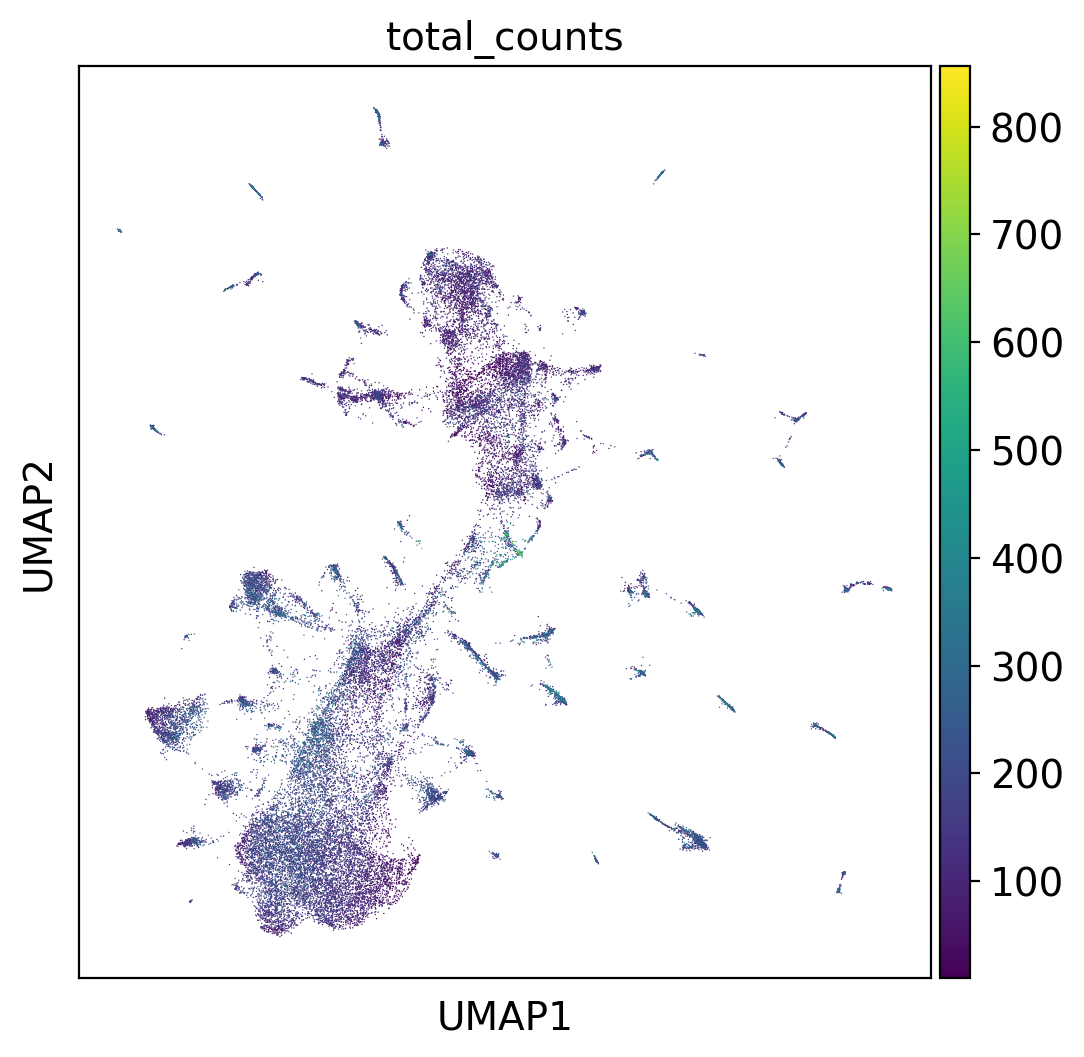

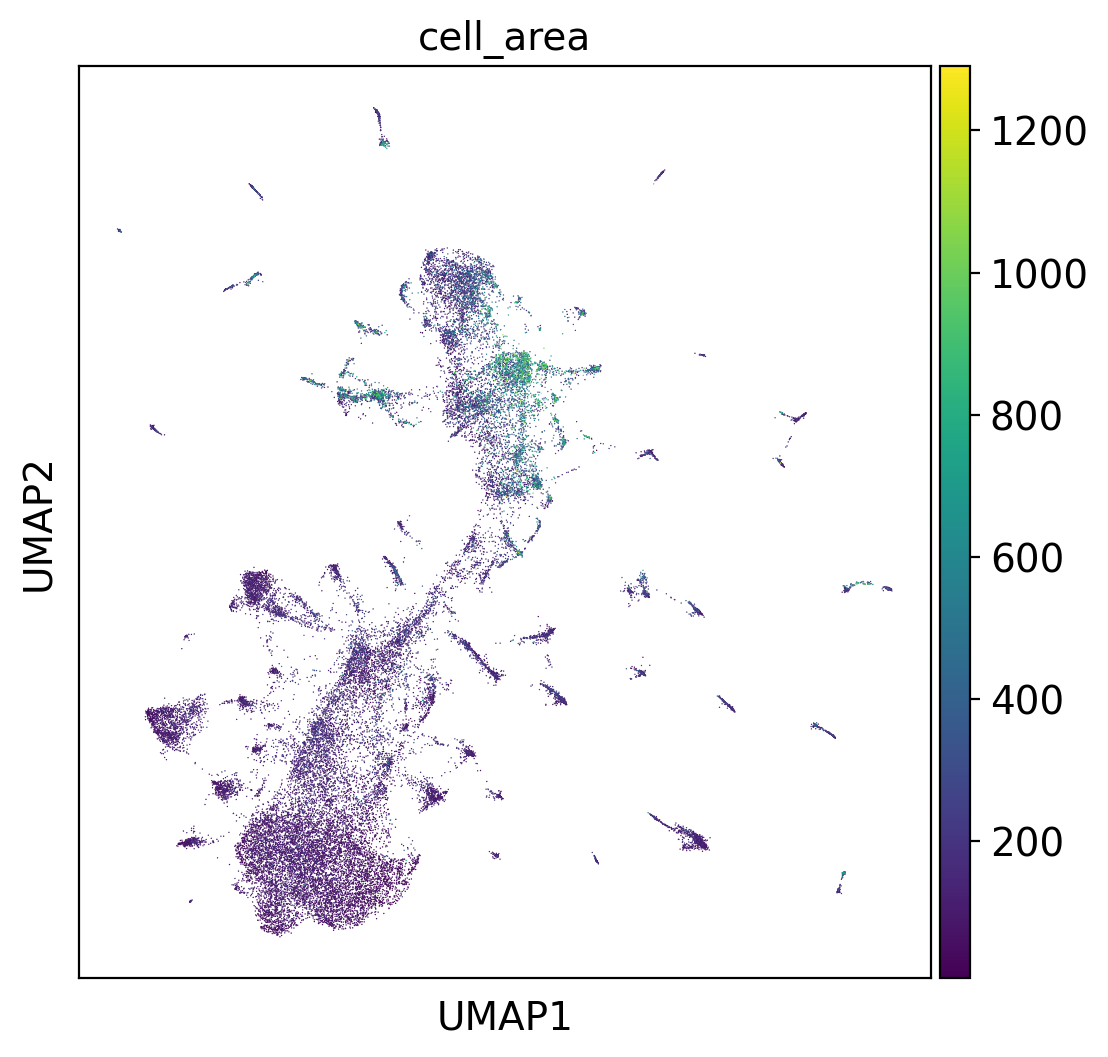

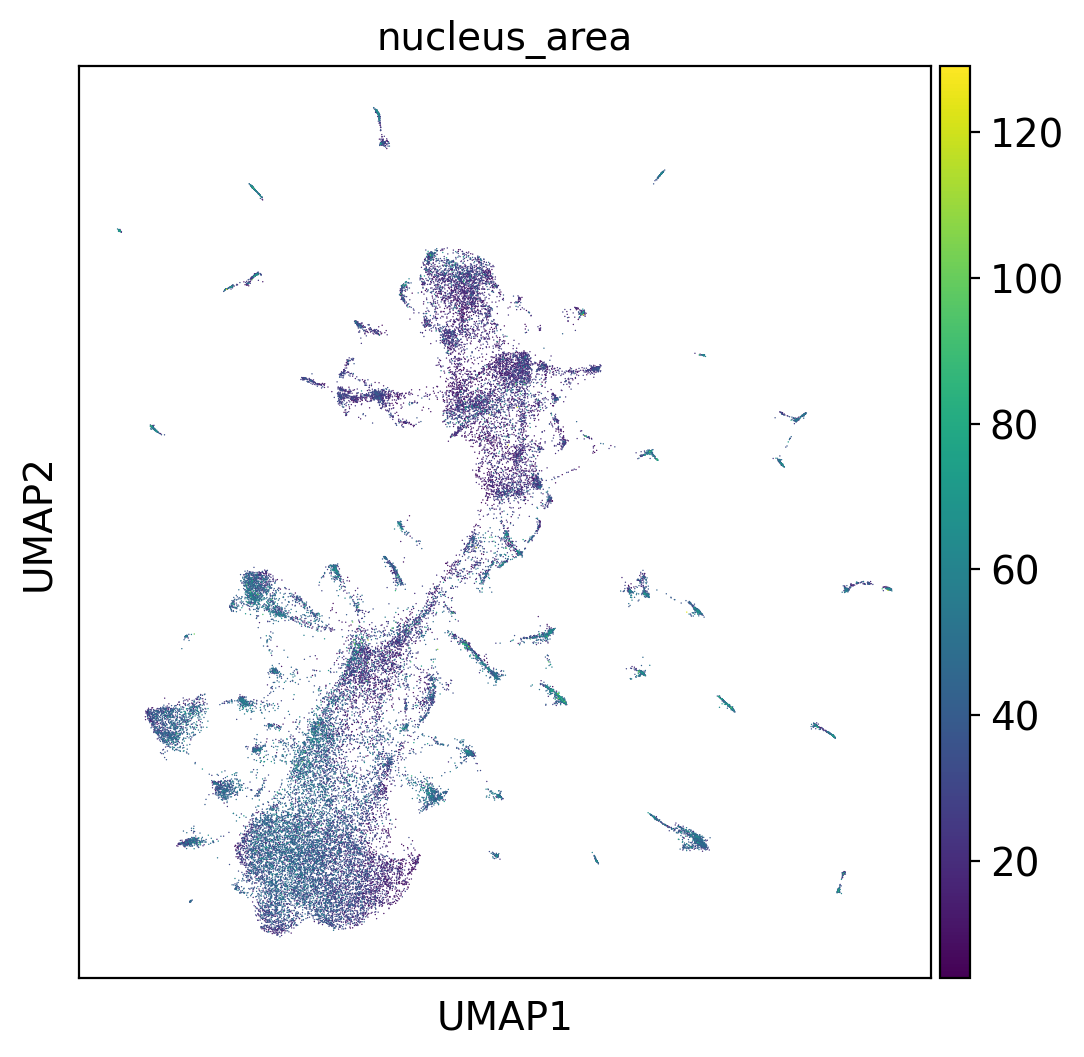

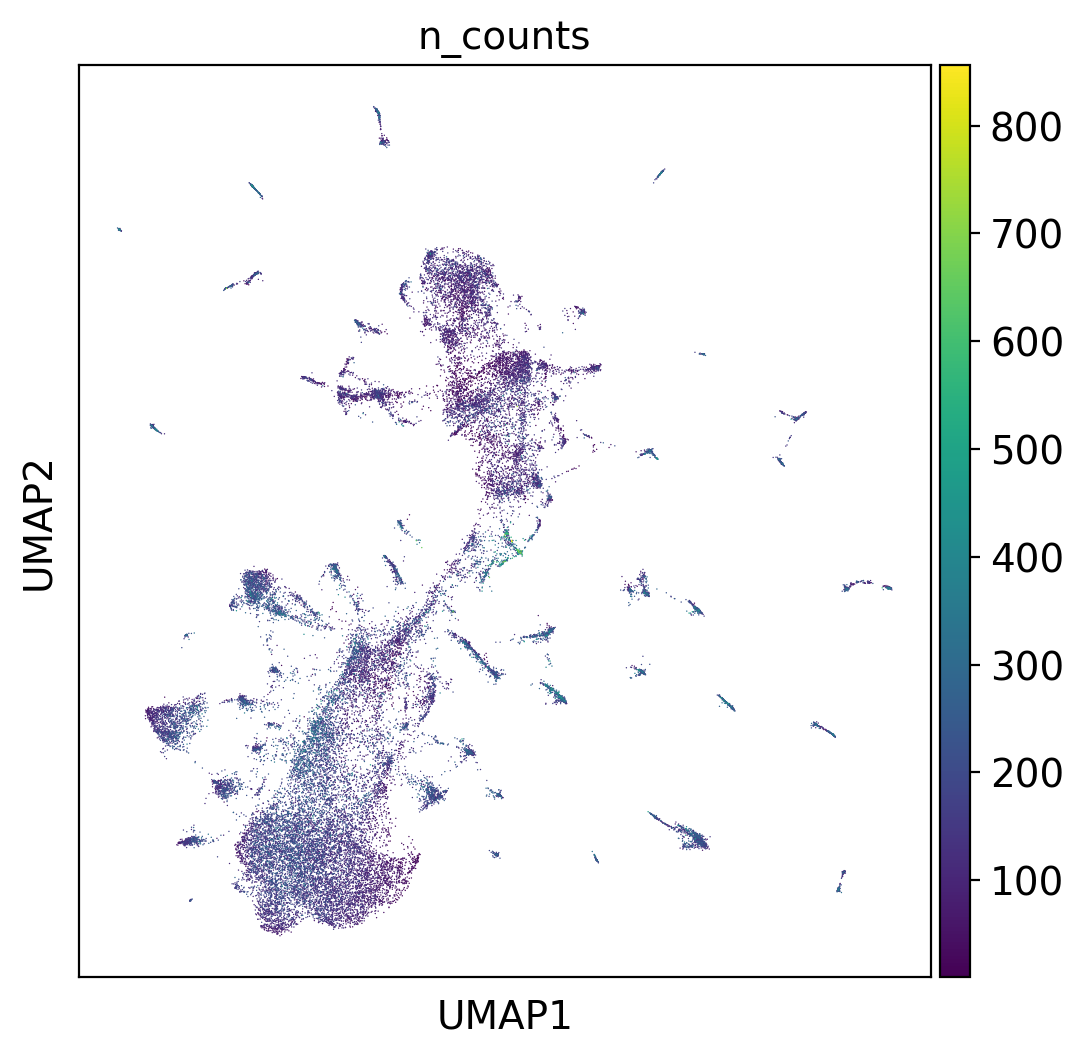

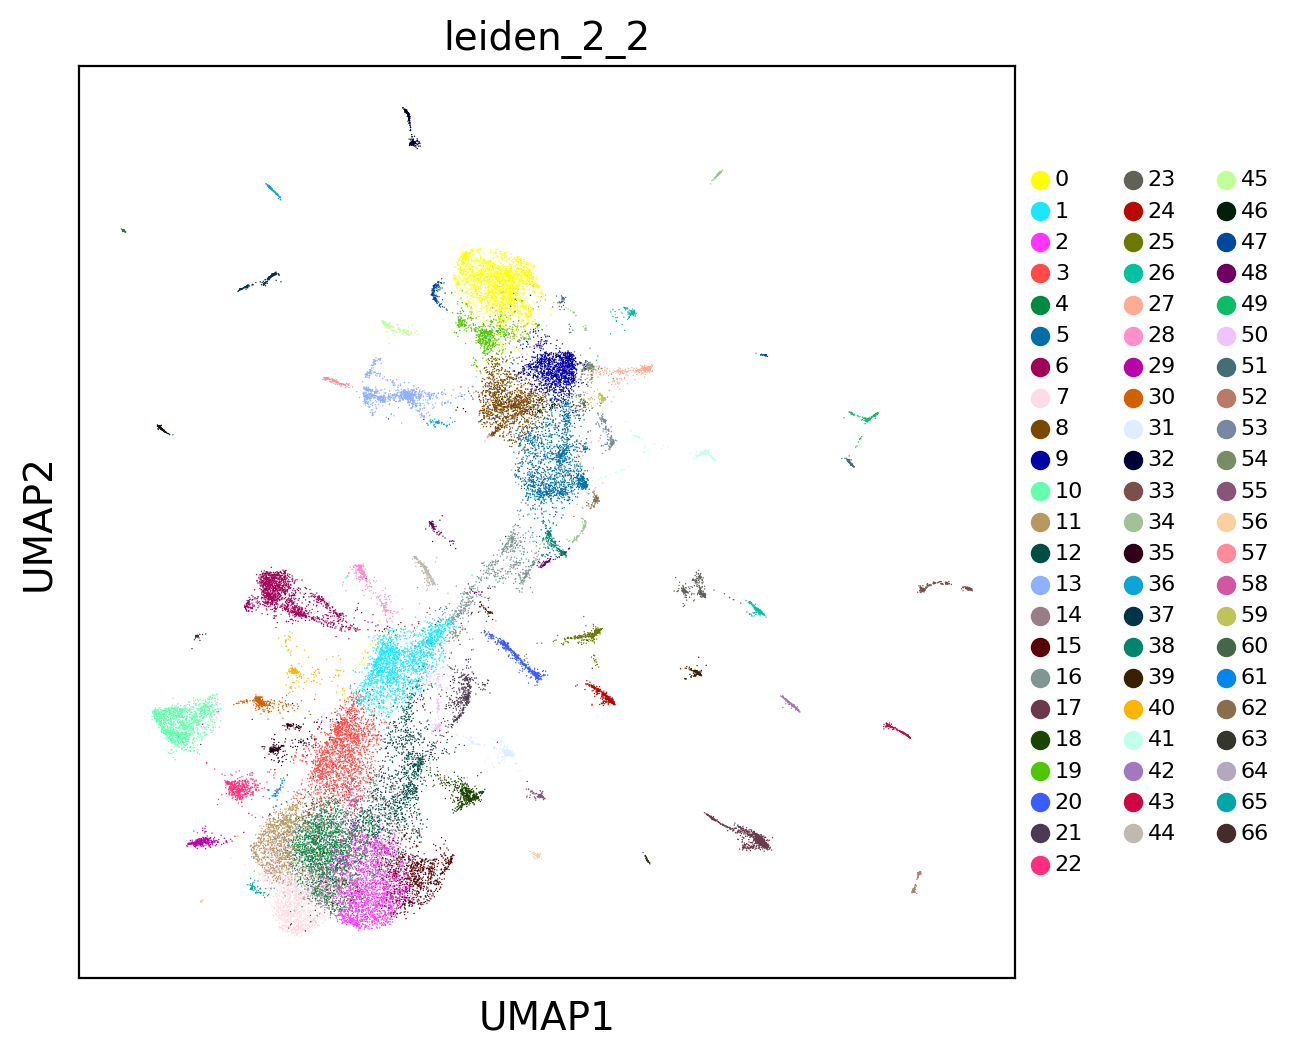

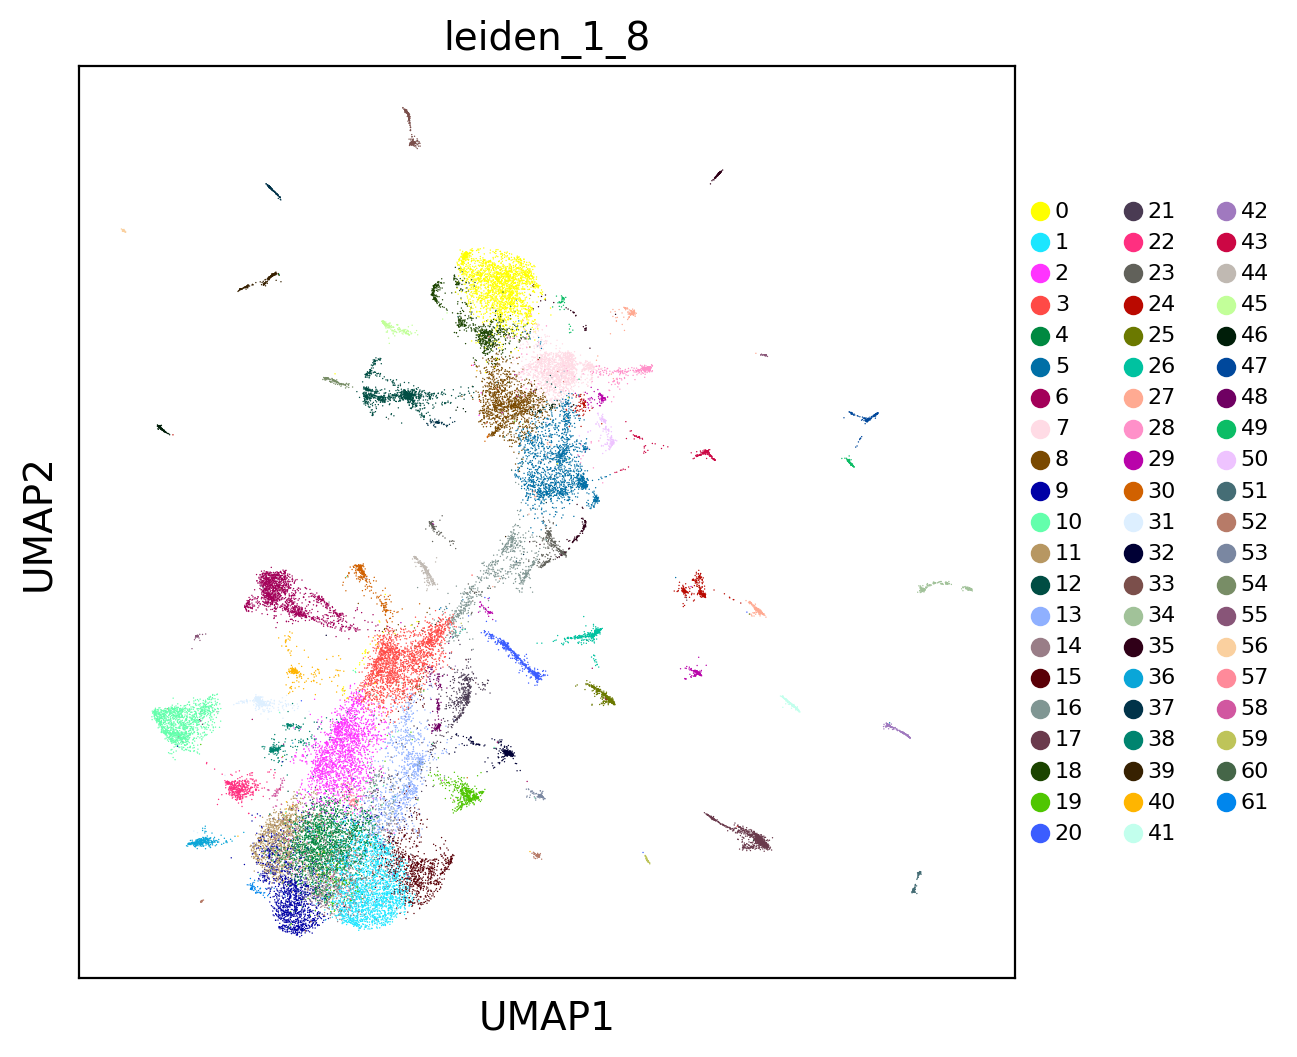

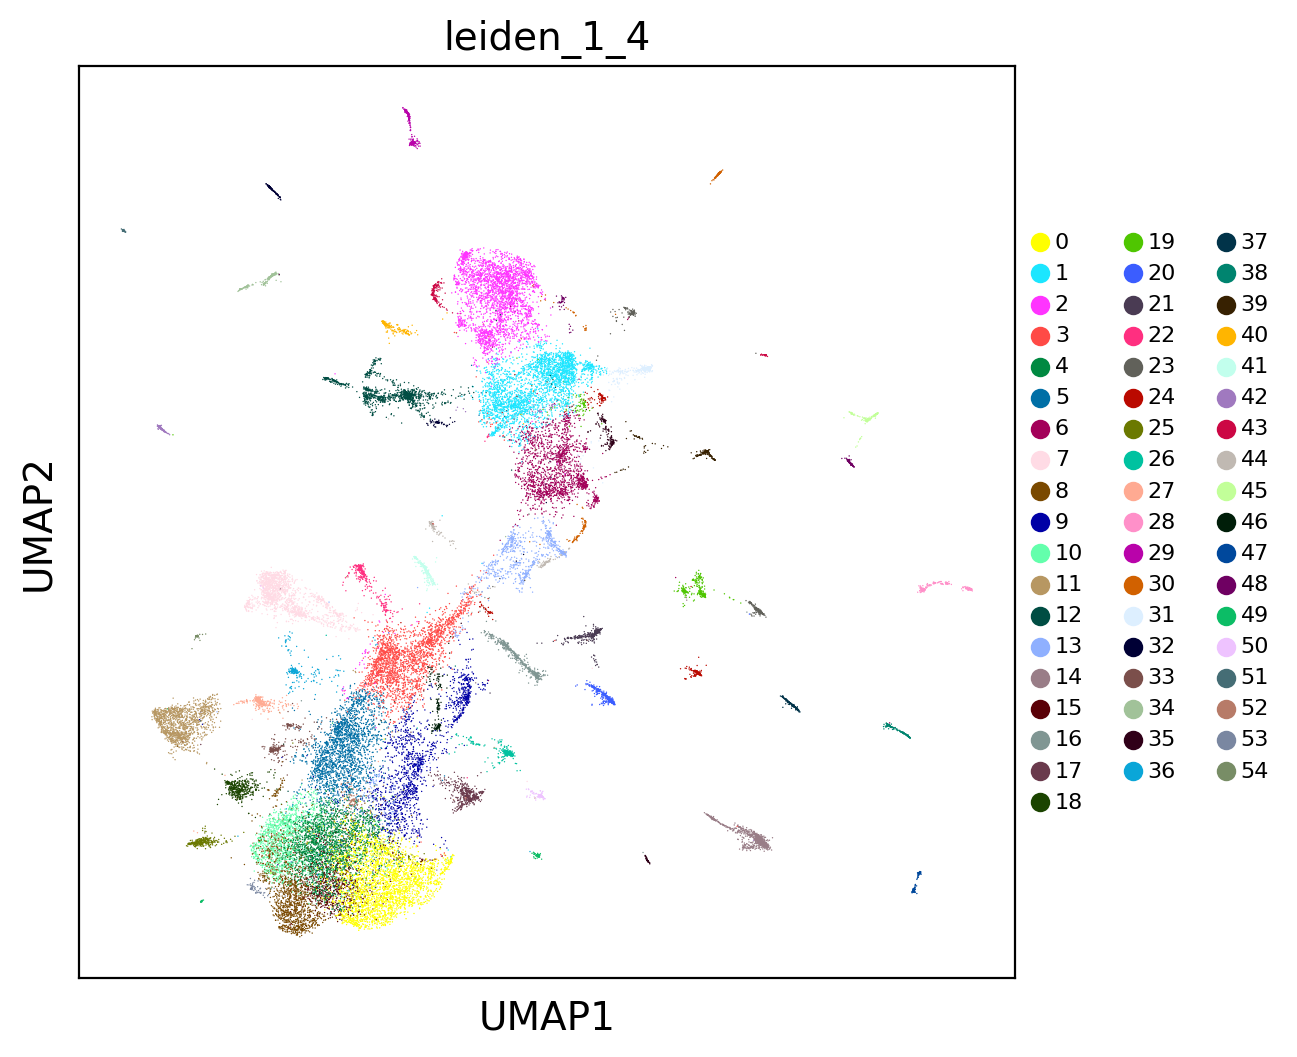

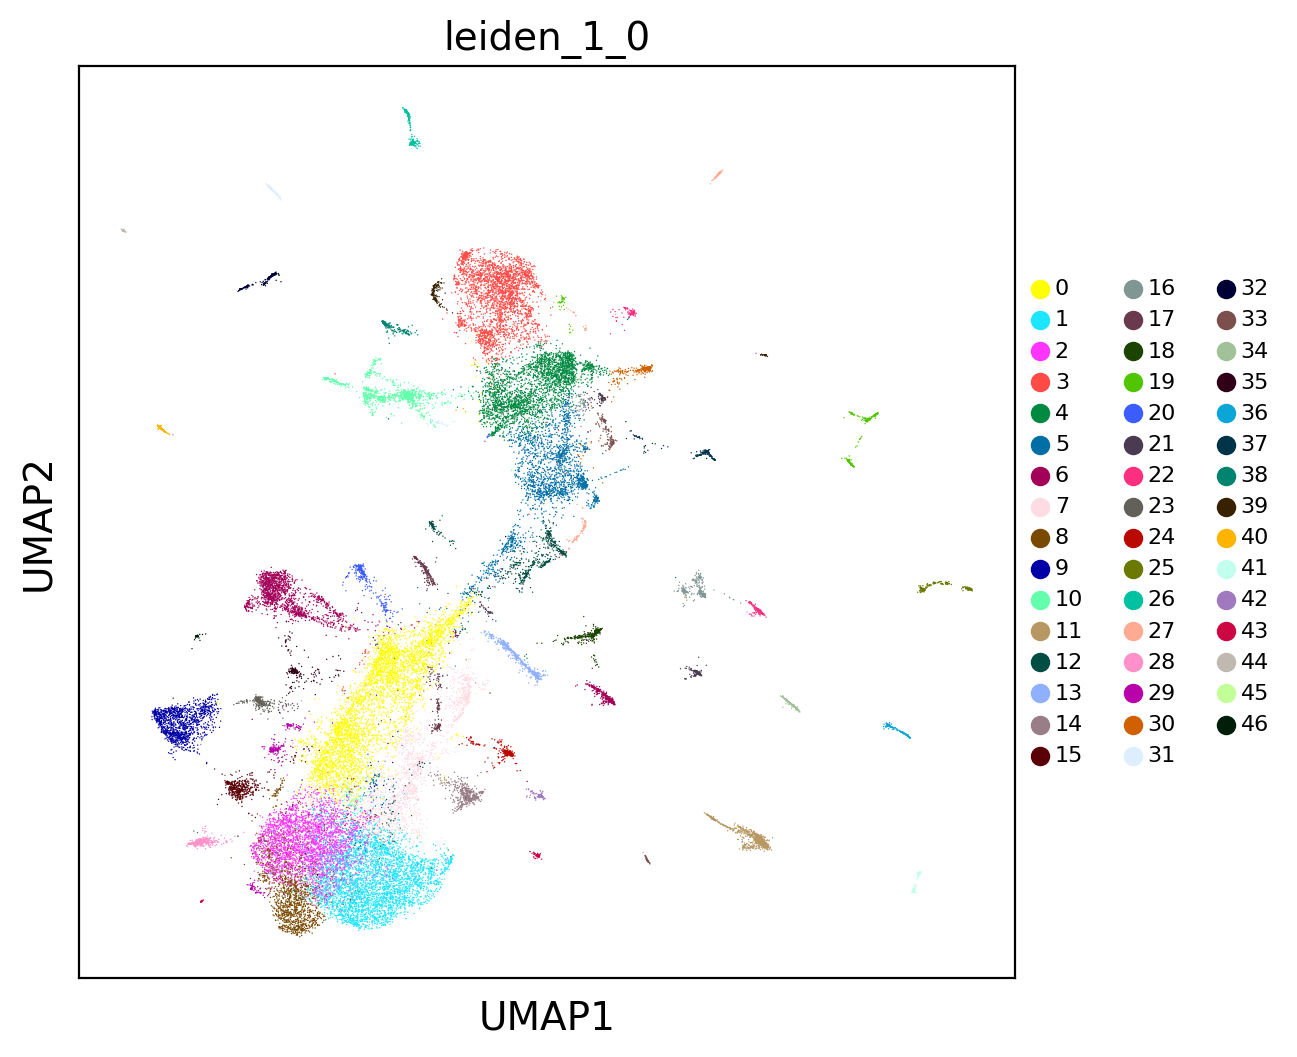

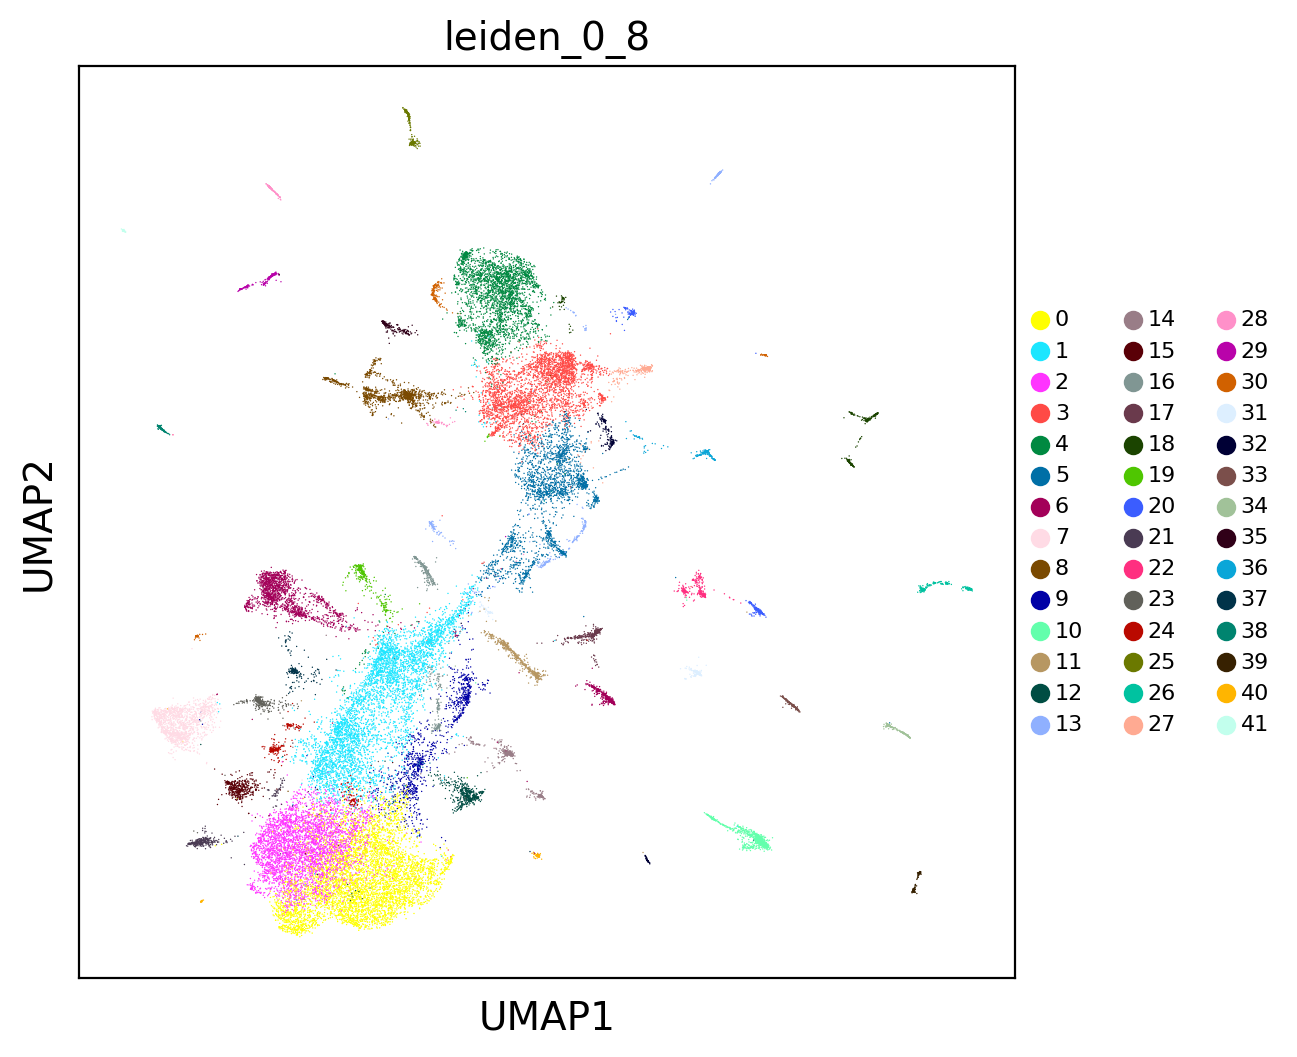

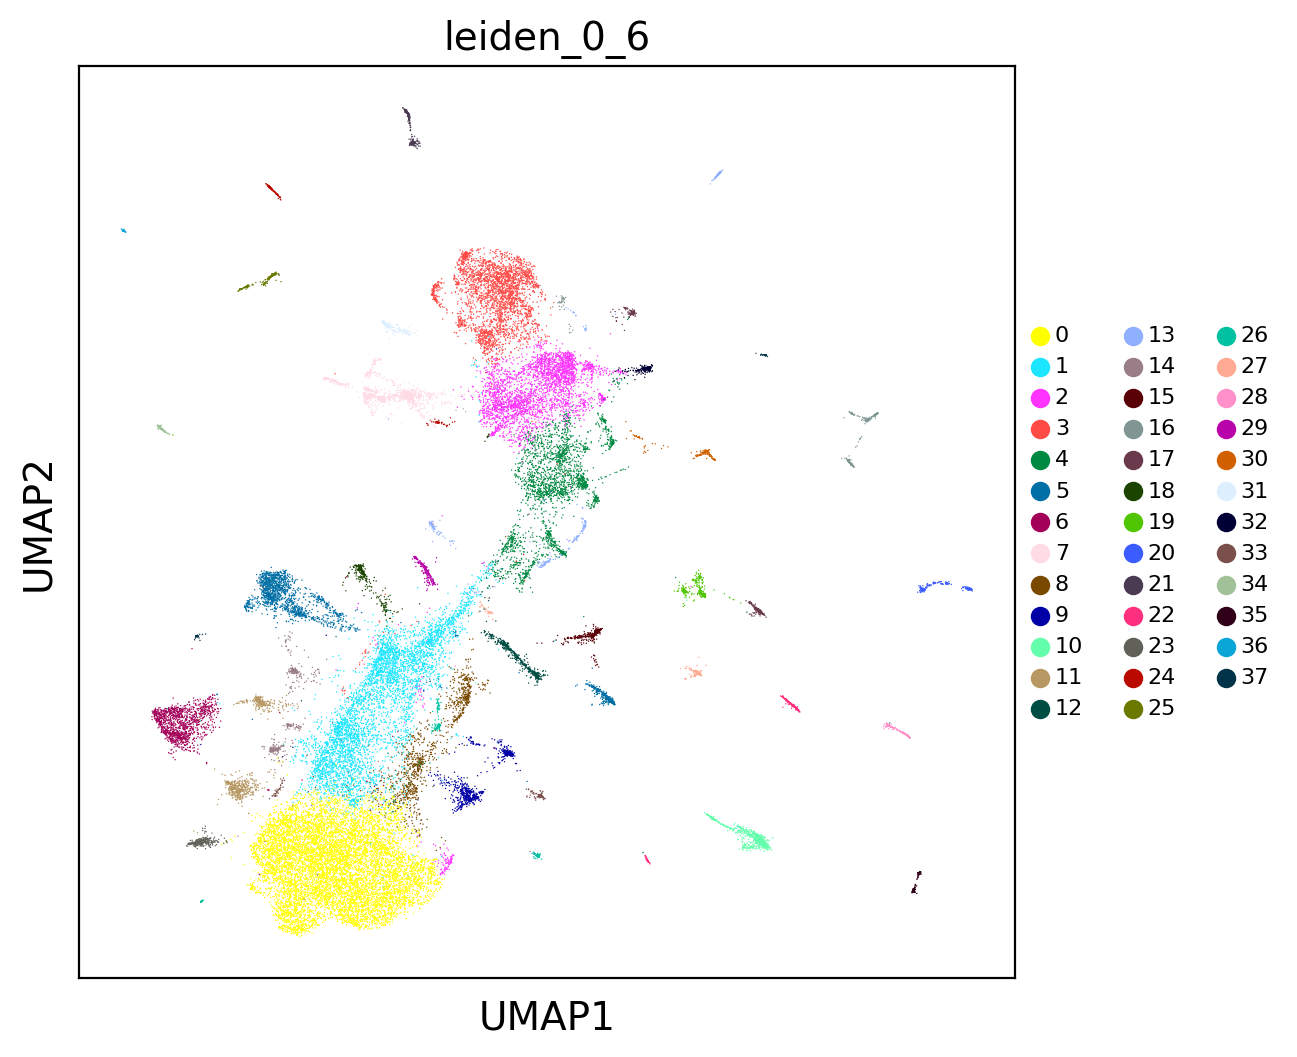

In [29]:
for col in plotting:
    sc.set_figure_params(scanpy=True, dpi=100,figsize=(6,6))
    plt.rcParams['figure.facecolor'] = 'white'
    sc.pl.umap(adata,color=[col],size=1,legend_fontsize=8,legend_fontoutline=2,show=False,cmap='viridis')
    plt.savefig('../../figures/'+output_folder+'/hbreast_1_'+str(col)+'.pdf',bbox_inches='tight')
    plt.show()

# Plotting clusters on the tissue

We now go back to the tissue and plot the clusters back. For this we use the function 'map_of_clusters' to plot clusters on the tissue

In [ ]:
adata.obs['X']=adata.obs['x_centroid']*4.70588
adata.obs['Y']=adata.obs['y_centroid']*4.70588
import scipy as sp
adata.X = sp.sparse.csr_matrix(adata.X)

In [ ]:
xp.map_of_clusters(adata,key='leiden_1_0',size=2,background='black',clusters='all',figuresize=(7,10),save='../../figures/'+output_folder,format='jpg')

In [ ]:
adata.obs['X_umap']=list(pd.DataFrame(adata.obsm['X_umap'])[0])
adata.obs['Y_umap']=list(pd.DataFrame(-adata.obsm['X_umap'])[1])
adatasub=adata
adatasubobs=adatasub.obs
adatasubobs.to_csv('../../data/celltyping_csv/hbreast_idc.csv')